# Performing classification supervised by the labels using a pretrained RESNET model

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
import glob

# Loading the dataset into a suitable dataloader

In [2]:
class DigitSumDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
image_files = sorted(glob.glob("../data/data*.npy"))
label_files = sorted(glob.glob("../data/lab*.npy"))

images = np.concatenate([np.load(f) for f in image_files], axis=0)  # Shape: (N, H, W)
labels = np.concatenate([np.load(f) for f in label_files], axis=0)  # Shape: (N,)

# Split into training and validation sets
split_ratio = 0.8
num_train = int(split_ratio * len(images))
num_val = len(images) - num_train

train_images, val_images = torch.utils.data.random_split(images, [num_train, num_val], generator=torch.Generator().manual_seed(42))
train_labels, val_labels = torch.utils.data.random_split(labels, [num_train, num_val], generator=torch.Generator().manual_seed(42))


In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resizing for ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizing for single-channel images
])

train_dataset = DigitSumDataset(train_images, train_labels, transform=transform)
val_dataset = DigitSumDataset(val_images, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [5]:
num_classes = len(np.unique(labels))  # Determine number of classes dynamically

model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change input channels to 1
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final layer

model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home2/yashas.b/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/yashas.b/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training the RESNET model

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}")

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_accuracies

In [7]:
train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20, Loss: 2.617624551932017
Validation Accuracy: 17.62%
Epoch 2/20, Loss: 2.1204434577624003
Validation Accuracy: 23.68%
Epoch 3/20, Loss: 1.8823033394813538
Validation Accuracy: 25.98%
Epoch 4/20, Loss: 1.679250718275706
Validation Accuracy: 38.22%
Epoch 5/20, Loss: 1.5021920619010924
Validation Accuracy: 38.97%
Epoch 6/20, Loss: 1.335998453617096
Validation Accuracy: 46.33%
Epoch 7/20, Loss: 1.1980599788824717
Validation Accuracy: 45.03%
Epoch 8/20, Loss: 1.0646344907283782
Validation Accuracy: 56.70%
Epoch 9/20, Loss: 0.9582442951997121
Validation Accuracy: 62.93%
Epoch 10/20, Loss: 0.8580625592072805
Validation Accuracy: 66.67%
Epoch 11/20, Loss: 0.750603099544843
Validation Accuracy: 70.17%
Epoch 12/20, Loss: 0.6631473970015843
Validation Accuracy: 65.55%
Epoch 13/20, Loss: 0.5824478305180868
Validation Accuracy: 80.38%
Epoch 14/20, Loss: 0.5563370395700137
Validation Accuracy: 75.65%
Epoch 15/20, Loss: 0.5037950611313184
Validation Accuracy: 80.33%
Epoch 16/20, Loss: 0.40

# Inference on the model

In [8]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy, all_predictions, all_labels

In [9]:
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

Test Accuracy: 82.57%


# Visualising the performance of the model

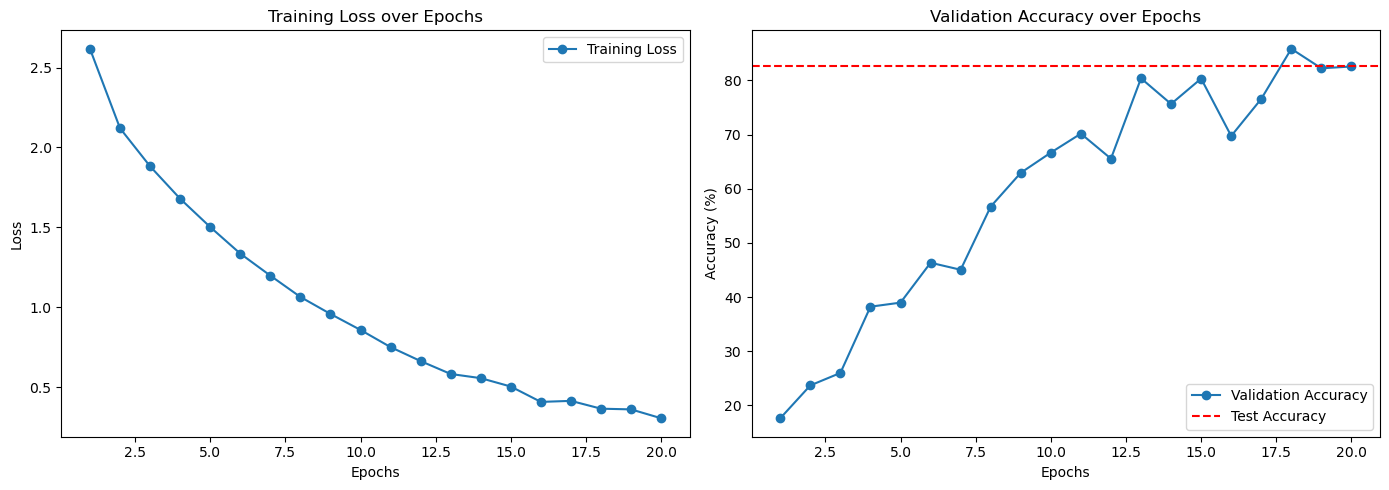

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(train_losses, val_accuracies, test_accuracy)

# Trying to evaluate the model using another synthetic dataset

In [11]:
from PIL import Image
import os

class ImageFolderDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, image_path  # Return image and its path for reference

image_folder = "../../../../scratch/yashas.b/double_mnist/992/" # predicted sum in this case should be 9 + 9 + 2 = 20

new_dataset = ImageFolderDataset(
    image_folder,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
)

image_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)

def evaluate_images(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    image_paths = []

    with torch.no_grad():
        for images, paths in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            image_paths.extend(paths)

    for path, prediction in zip(image_paths, all_predictions):
        print(f"Image: {path}, Predicted Sum: {prediction}")

# Evaluate
evaluate_images(model, image_loader)

FileNotFoundError: [Errno 2] No such file or directory: '../../../../scratch/yashas.b/double_mnist/992/'